# Deep learning example code and workbook

In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

In [2]:
# Load the mnist dataset, which consists of hand-written digits, of size 28x28 pixels
mnist = datasets.fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)


## Convnet basics

In [3]:
import numpy as np
import numpy.linalg as linalg

from typing import List,Tuple

In [4]:
def conv2dSimple(image: np.ndarray, filter: np.ndarray) -> np.ndarray:
    """Does a naive convolution between an image and a filter

    Args:
        image (np.ndarray): a (batch_size, input_width, input_width, nr_color_channels) dimensional array that encodes the images
        filter (np.ndarray): a (filter_width, filter_height, nr_color_channels, nr_filters) dimensional array of filters that are applied to the images

    Returns:
        np.ndarray: the convolved images
    """
    # Height and width of output image
    Hout = image.shape[1] - filter.shape[0] + 1
    Wout = image.shape[2] - filter.shape[1] + 1

    output = np.zeros([image.shape[0], Hout, Wout, filter.shape[3]])

    for n in range(output.shape[0]):  # loop over each image
        for x_i in range(output.shape[1]): # loop over the horizontal axis
            for y_j in range(output.shape[2]): # loop over the vertical axis
                for cout in range(output.shape[3]): # loop overt the filters
                    # Numpy multiply does a point-wise multiplication
                    output[n, x_i, y_j, cout] = np.multiply(
                        image[
                            n,
                            x_i : x_i + filter.shape[0],
                            y_j : y_j + filter.shape[1],
                            :,
                        ],
                        filter[:, :, :, cout],
                    ).sum() # which then sum over to get the output pixel value

    return output


In [5]:
# a set of filters in (nr_filters, filter_height, filter_width) format
filters = np.array(
    [
        [[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]],  # a vertical edge detecter
        [[-1, -1, -1], [2, 2, 2], [-1, -1, -1]],  # a horizontal edge detector
        [[1, 1, 1], [1, -8, 1], [1, 1, 1]],  # ridge detection
        [[1, 1, 1], [1, 1, 1], [1, 1, 1]],  # blurring/superpixel
    ]
)

# Normalization and transposing so it fits in the function above
# We need the transpose, because the above function is channel-last
filters = filters / linalg.norm(filters, axis=(1,2), keepdims=True)
filters = np.transpose(filters, axes=(1,2,0)) # Put the first channel as the last (nr_filters should be last)
filters = np.expand_dims(filters, 2) # Put in an extra dimension of size 1 for the color channel

### Question:
How would you implement a modification of the above convolution function which can do padding and strides?

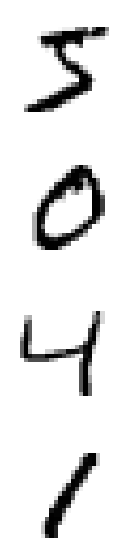

In [6]:
_, axes = plt.subplots(nrows=4, ncols=1, figsize=(3, 10))
for ax, image, label in zip(axes, mnist[0], mnist[1]):
    ax.set_axis_off()
    ax.imshow(np.reshape(image,(28,28)), cmap=plt.cm.gray_r, interpolation="nearest")


In [7]:
# Try the filters on these examples
outputs = conv2dSimple(np.expand_dims(np.reshape(mnist[0][:4],(-1,28,28)),-1),filters)

In [8]:
# we see that the output has the correct shape. We start with 4 pictures of size 28 by 28 pixels.
# The output has 4 output channels (4 filters)
# We lose 1 pixel on each side and the top and bottom, because the function doesn't use padding
outputs.shape

(4, 26, 26, 4)

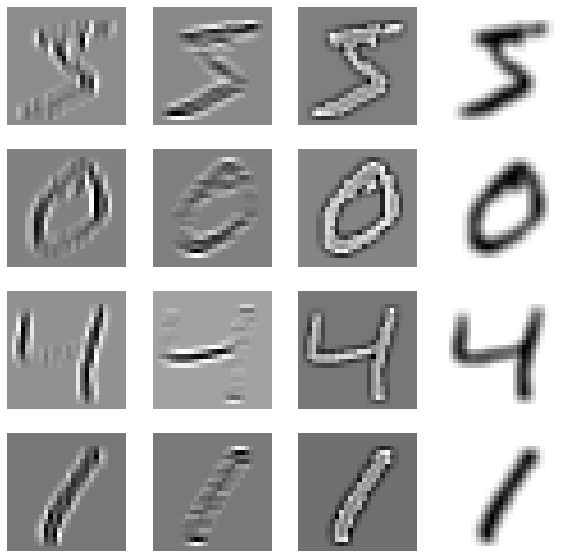

In [9]:
# Each different filter has a different output.
# The first filter is a vertical edge detection filter
# The second one is a horizontal edge detection filter
# The third one is a ridge detection filter
# The fourth one is a blur filter
_, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for ax, image in zip(axes[:,i], outputs[:,:,:,i]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")


### Question:
Try out a different set of filters. Can you predict what a filter does based on the filter values?

## Convnets

In [10]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim

We define a class implementing a specific (Convolutional) Neural Network.

There are multiple ways of defining neural networks within Pytorch. 

We use the object-oriented way, because it is flexible enough to easily build a variational auto-encoder

The class needs to inherit from nn.Module and define a forward method, which produces the output of the neural network based on an input tensor and the parameters of the network.

The init method needs to define all of the trainable parameters of the network.

PyTorch defines many convenient steps that make up a neural network including in `torch.nn` module like:
- Linear steps like `Linear`, and `Conv2d` (no non-linear activation included)
- Activation functions like `ReLU`, `LogSoftmax` (for multiclass classification), `Sigmoid` and `Tanh`
- Other various useful functions like `BatchNorm2d`, `MaxPool2d`, `Dropout2d`

Each of these steps is again an object, with possible initialization options.

Each of these is callable, meaning if you instantiate for example.

`conv_layer = Conv2d(in_channels = 1, out_channels = 4, kernel_size=(3,3))`

you can then apply it to the data x as:

`output = conv_layer(x)`

The first dimension of a tensor is assumed to be the batch dimension (i.e. each row is a new example) and is not modified by the steps, and each row is acted upon independently.

We can string layers together quickly by putting them in Sequential block, where each layer in the sequential object acts upon the input successively.

PyTorch also defines optimizer functions in torch.optim. You need to specify the type of optimizer you want to use, some parameters governing the optimizer (for example you can specify a custom learning rate), and the parameters you want to optimize (which can be gotten by calling `.parameters()` on the network you have defined)

While doing a forward pass on a batch of data, PyTorch will keep track of the intermediate values and the computation graph needed to compute the gradient. Once you have calculated the loss function for that particular batch, you call `loss_function.backward()` to do backpropagation on the computation graph, and `optimizer.step()` will optimize the parameters of the network.

PyTorch will automatically calculate the derivatives (automatic differentiation).

Things to keep in mind:
- You need to zero-out your gradient after each time you've optimized, otherwise you will accumulate them which will lead to wrong answers
- If you need an output without doing a gradient calculation, you can `.detach()` it, which means you will drop it from the computation graph

PyTorch also can make use of a GPU by sending both the network and the tensors on which it operates to a GPU, of which we will see an example later 

In [11]:


class MNISTClassifier(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        # Define the convolutional steps of the network
        # We group them together in a Sequential step for convenience
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels = 8, kernel_size=(3,3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size=(3,3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(3,3), padding="same"),
            nn.ReLU(),
        )
        
        # get the correct output size of the convolutional step
        self.conv_out_size = self._get_enc_out(input_shape)

        # define the final (fully connected) layer
        self.linear_layer =  nn.Sequential(
            nn.Linear(in_features=self.conv_out_size, out_features = 10), # 10 here because we have 10 output classes for MNIST
        )


    def _get_enc_out(self, shape):
        """Small helper function that determines the number of pixels output by the conv-layer"""
        o = self.convnet(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.convnet(x)
        out = self.linear_layer(conv_out.reshape((-1,self.conv_out_size)))
        return nn.LogSoftmax(dim=-1)(out) # Do a softmax on the output

In [12]:
BATCH_SIZE = 32
TRAIN_FRAC = 0.8

# initialize the network
mnist_class = MNISTClassifier((1, 28, 28))

# Define the optimizer, and tell it which parameters to optimize
optimizer = optim.Adam(mnist_class.parameters())

# Construct the training and test set
total_set = list(zip(mnist[0], mnist[1].astype(int)))
train_size = int(TRAIN_FRAC * len(total_set))
train_set = total_set[:train_size]
test_set = total_set[train_size:]

# Train for 2 epochs
for i in range(2):
    for batch in range(0, len(train_set)-BATCH_SIZE, BATCH_SIZE):
        # Extract the training batch from the whole set
        # Ideally you want to sample randomly, or shuffle the training set each time you go through it
        train_X, train_y = list(zip(*train_set[batch:batch+BATCH_SIZE]))
        train_X = torch.Tensor(np.reshape(train_X, (-1, 1, 28, 28)))
        train_y = torch.Tensor(train_y).to(torch.int64)
        
        # Initialize the optimizer to 0 gradient
        optimizer.zero_grad(set_to_none=True)

        # Determine the output class
        out = mnist_class.forward(train_X)
        
        # Calculate the loss function
        loss = F.nll_loss(out,train_y)
        
        # Do backward propagation on the loss function
        loss.backward()
        print(loss.detach()) # The detach is to decouple this step from the gradient calculation
        
        # Optimize the parameters
        optimizer.step()


tensor(13.1784)
tensor(6.6248)
tensor(5.7185)
tensor(5.2625)
tensor(6.2659)
tensor(4.9438)
tensor(3.9535)
tensor(2.4978)
tensor(3.2626)
tensor(2.6524)
tensor(2.0010)
tensor(1.9950)
tensor(1.5679)
tensor(0.8344)
tensor(0.3924)
tensor(1.6986)
tensor(1.2323)
tensor(0.6618)
tensor(1.1674)
tensor(1.2519)
tensor(1.1680)
tensor(0.5269)
tensor(0.7099)
tensor(0.9868)
tensor(0.6206)
tensor(0.4793)
tensor(0.8981)
tensor(0.5152)
tensor(0.7294)
tensor(0.4339)
tensor(0.4637)
tensor(0.8091)
tensor(0.8857)
tensor(0.6799)
tensor(0.5358)
tensor(0.8842)
tensor(0.4825)
tensor(0.4719)
tensor(0.9125)
tensor(0.5176)
tensor(0.3536)
tensor(0.4546)
tensor(0.5939)
tensor(0.5108)
tensor(0.4375)
tensor(0.3234)
tensor(0.2986)
tensor(0.5507)
tensor(0.3293)
tensor(0.3445)
tensor(0.5612)
tensor(0.1492)
tensor(0.3724)
tensor(0.0798)
tensor(0.2262)
tensor(0.3684)
tensor(0.2058)
tensor(0.2237)
tensor(0.2017)
tensor(0.3944)
tensor(0.3790)
tensor(0.3028)
tensor(0.2263)
tensor(0.6025)
tensor(0.3250)
tensor(0.3766)
tensor(0.

In [13]:
# Determine the accuracy on the test set
# Should be around 98%
test_X, test_y = list(zip(*test_set))
test_X = torch.Tensor(np.reshape(test_X, (-1, 1, 28, 28)))
test_pred = mnist_class(test_X)
print(f"accuracy: { (np.array(test_y) == torch.argmax(test_pred,axis=1).numpy()).mean():.3%}")

accuracy: 98.264%


In [14]:
# Get the intermediate activiation functions of the convnet

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
mnist_class.convnet[1].register_forward_hook(get_activation('layer_1'))
mnist_class.convnet[4].register_forward_hook(get_activation('layer_2'))
mnist_class.convnet[7].register_forward_hook(get_activation('layer_3'))

Here we show for an example the different activations of the network for each layer
### Question:
Can you also interpret the activation of the final linear layer?

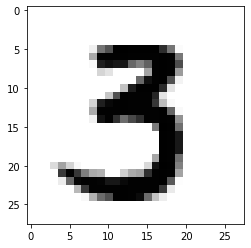

In [15]:
example_index = 12

mnist_class(torch.tensor(test_set[example_index][0].reshape(1,1,28,28).astype(np.float32)))
plt.imshow(test_set[example_index][0].reshape(28,28),cmap=plt.cm.gray_r, interpolation="nearest")


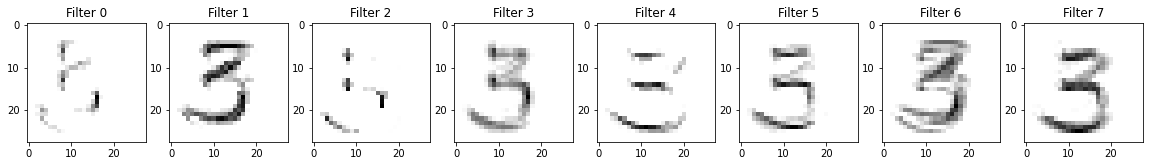

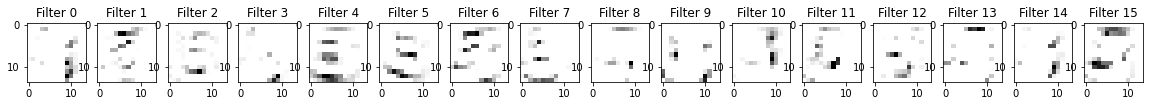

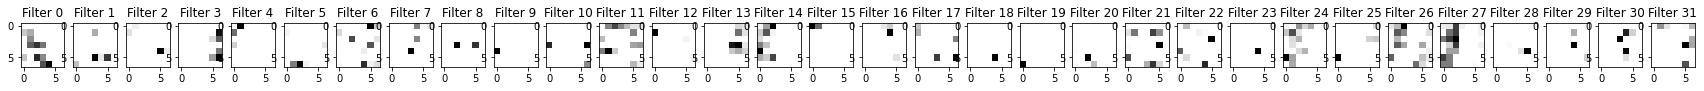

In [16]:
_, axes = plt.subplots(nrows=1, ncols=8, figsize=(20, 6))
for i,ax_i in enumerate(axes):
    filter_output = activation['layer_1'][0,i,:,:].numpy()
    ax_i.imshow(filter_output, cmap=plt.cm.gray_r, interpolation="nearest")
    ax_i.set_title(f"Filter {i}")

_, axes = plt.subplots(nrows=1, ncols=16, figsize=(20, 6))
for i,ax_i in enumerate(axes):
    filter_output = activation['layer_2'][0,i,:,:].numpy()
    ax_i.imshow(filter_output, cmap=plt.cm.gray_r, interpolation="nearest")
    ax_i.set_title(f"Filter {i}")

_, axes = plt.subplots(nrows=1, ncols=32, figsize=(30, 12))
for i,ax_i in enumerate(axes):
    filter_output = activation['layer_3'][0,i,:,:].numpy()
    ax_i.imshow(filter_output, cmap=plt.cm.gray_r, interpolation="nearest")
    ax_i.set_title(f"Filter {i}")

## Variational Autoencoders

We define a very basic variational autoencoder here, which we'll train on the MNIST dataset to generate new digits.

Training it will take a 1-2 minutes (depending on the speed of the computer/instance you're training it on)

The autoencoder consists of 3 basic parts as defined in the lecture:
- An encoder which outputs a \mu and \sigma for each example
- A sampler which samples from a random normal distribution and generates a z-value using the computed \mu and \Sigma
- A decoder which transforms the z-value into an image of the same size as the input

The loss function now needs to combine both the input image, the output image and \mu and \Sigma, and we'll see how easy this is to do within PyTorch

In [17]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_shape: Tuple, latent_dim: int):
        super().__init__()
        
        # Define encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape[0],
                out_channels=8,
                kernel_size=(3, 3),
                padding=1,
                stride=2, # We use stride here instead of maxpooling, because we care more about the pixel level at the end
                # Also, this makes it easier to get the right Conv2DTranspose to get back to the same picture size
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, stride=2
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, stride=2
            ),
            nn.ReLU(),
        )

        # Define the latent space manipulations
        self.output_flat, self.output_full = self._get_enc_out(input_shape)
        self.latent_dim = latent_dim
        self.mu = nn.Linear(self.output_flat, latent_dim)
        self.log_var = nn.Linear(self.output_flat, latent_dim)

        # Go back to the convnet
        self.decoder_input = nn.Linear(latent_dim, self.output_flat)

        # Decode the latent space representation back into an image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=32, out_channels=16, kernel_size=(3, 3), stride=2, padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=16, out_channels=8, kernel_size=(3, 3), stride=2, padding=1, output_padding=1 # We need output padding here to resolve the ambiguity
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=8, out_channels=8, kernel_size=(3, 3), stride=2, padding=1, output_padding=1 # Again need for output padding
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=1, padding="same"), # a final layer to combine all the remaining channels together
        )

    def _get_enc_out(self, shape: Tuple[int]) -> Tuple[int]:
        """Helper function which determines the shape of the encoder output"""
        o = self.encoder(torch.zeros(1, *shape))
        return [int(np.prod(o.size())), o.size()[1:]]

    def encode(self, input: torch.Tensor) -> torch.Tensor:
        """Determines the mu and log variance output of the encoder"""
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.mu(result)
        log_var = self.log_var(result) # We don't actually use \sigma here, but the log of the variance
        return [mu, log_var]

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decodes the sampled z back to an image"""
        result = self.decoder_input(z)
        result = result.view(-1, *self.output_full)
        result = self.decoder(result)
        result = nn.Sigmoid()(result)
        return result

    def reparametrize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        """Calculates the sampled z, with the reparametrization 'trick'"""
        std = torch.exp(0.5 * log_var) # We need to convert the log of the variance back to a standard deviation
        eps = torch.randn_like(std) # Sample an epsilon
        return eps * std + mu

    def forward(self, input: torch.Tensor) -> List[torch.Tensor]:
        """Calculates the whole step, and outputs the reconstructed image and mu and log of the variance"""
        mu, log_var = self.encode(input)
        z = self.reparametrize(mu, log_var)
        return [input, self.decode(z), mu, log_var]


In [18]:
vae = VariationalAutoEncoder(input_shape = (1,28,28), latent_dim= 16)

In [19]:
print(vae)

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (mu): Linear(in_features=512, out_features=16, bias=True)
  (log_var): Linear(in_features=512, out_features=16, bias=True)
  (decoder_input): Linear(in_features=16, out_features=512, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)
  )
)


In [20]:
# check to see the intermediate and output shape
vae_output = vae.forward(torch.zeros(4,1,28,28))
print(f"Input shape: {vae_output[0].shape}")
print(f"Output shape: {vae_output[1].shape}")
print(f"Latent space shape: {vae_output[2].shape}")
print(f"Shape before/after latent space: {vae.output_full}")

Input shape: torch.Size([4, 1, 28, 28])
Output shape: torch.Size([4, 1, 28, 28])
Latent space shape: torch.Size([4, 16])
Shape before/after latent space: torch.Size([32, 4, 4])


In [31]:
def vae_loss_function(input_img:torch.Tensor, output_img:torch.Tensor, mu:torch.Tensor, log_var:torch.Tensor, beta = 0.01) ->dict:
    reconstruction_loss = F.binary_cross_entropy(input_img, output_img)
    # You could try a different loss function to see if that makes the reconstructed images look better
    # reconstruction_loss = F.mse_loss(input_img, output_img)
    kld_loss = torch.mean(-0.5 * torch.sum(1+ log_var - mu**2 - log_var.exp(), dim=1), dim=0)
    loss = reconstruction_loss + beta*kld_loss # We assign a smaller weight to the KL Divergence loss
    return {'loss': loss, 'Reconstruction loss': reconstruction_loss.detach(), 'KLD': kld_loss.detach()}


In [32]:
# We want to put all this training the GPU, in order to speed things up
device = torch.device('cuda')


In [33]:
BATCH_SIZE = 32
TRAIN_FRAC = 0.8
EPOCHS = 6

vae = VariationalAutoEncoder(input_shape = (1,28,28), latent_dim= 16).to(device)
optimizer = optim.Adam(vae.parameters(),lr=0.01)

# Put the dataset directly on the GPU device, so we don't spend too much time copying stuff to the GPU all the time
total_set = torch.reshape(torch.Tensor(mnist[0]).to(device), (-1,1,28,28)) / 255
train_size = int(TRAIN_FRAC * len(total_set))
train_set = total_set[:train_size]
test_set = total_set[train_size:]
for i in range(EPOCHS):
    rec_loss = []
    kl_loss = []
    for batch in range(0, train_size-BATCH_SIZE, BATCH_SIZE):
        train_X = train_set[batch:batch+BATCH_SIZE]
        # We clip because the loss function goes to infinity at the edges
        train_X = torch.clip(train_X, 1e-6, 1 - 1e-6)

        # Reset the gradients to 0
        optimizer.zero_grad(set_to_none=True)

        # Compute the output images and intermediate mu and log of the variance
        output_img, input_img, mu, log_var = vae.forward(train_X)

        # compute the combined loss function
        loss = vae_loss_function(input_img, output_img, mu, log_var)

        # Do backpropagation
        loss['loss'].backward()
        rec_loss.append(loss['Reconstruction loss'].cpu().numpy()) # we need to put the loss function back to the cpu in order to print it.
        kl_loss.append(loss['KLD'].cpu().numpy())

        # Optimize the parameter
        optimizer.step()
    print(f"Reconstruction loss at epoch {i}: {np.mean(rec_loss):.4f}")
    print(f"KL Divergence loss at epoch {i}: {np.mean(kl_loss):.4f}")



Reconstruction loss at epoch 0: 0.2692
KL Divergence loss at epoch 0: 0.0201
Reconstruction loss at epoch 1: 0.2647
KL Divergence loss at epoch 1: 0.0025
Reconstruction loss at epoch 2: 0.2645
KL Divergence loss at epoch 2: 0.0023
Reconstruction loss at epoch 3: 0.2646
KL Divergence loss at epoch 3: 0.0023
Reconstruction loss at epoch 4: 0.2645
KL Divergence loss at epoch 4: 0.0022
Reconstruction loss at epoch 5: 0.2644
KL Divergence loss at epoch 5: 0.0020


### Question
Observe that the reconstruction loss is much lower than the KL divergence loss, and that the KL divergence loss actually goes up during training.

What could be an explanation for that?



In [29]:
# Take a sample of the VAE latent sample space and create some images from them
sample = vae.decode(torch.randn(8,16,device=device)*2).detach().cpu().numpy()

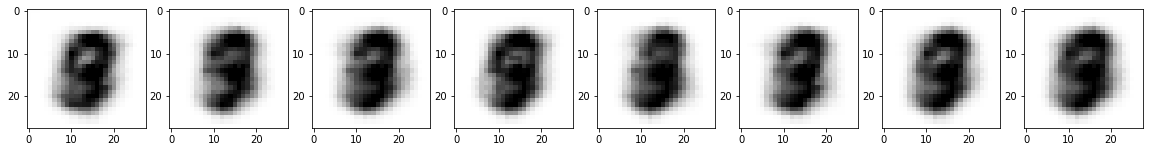

In [30]:
_, axes = plt.subplots(nrows=1, ncols=8, figsize=(20, 6))
for i in range(8):
    axes[i].imshow(sample[i].reshape(28,28),cmap=plt.cm.gray_r, interpolation="nearest")

## Some further directions to explore

In [26]:
import torchvision

# Possible datasets are MNIST (which you've seen already)
# FashionMNIST (MNIST, but with fashion items, black and white)
# CIFAR10 (10 image class for image classification, colors!)
# CELEBA (pictures of celebrities, also colors)
# Full list at https://pytorch.org/vision/stable/datasets.html


In [49]:
train_loader = torch.utils.data.DataLoader(
torchvision.datasets.CIFAR10('.', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               ])),
  batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('.', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=16, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([32, 3, 32, 32])


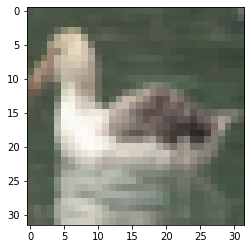

In [52]:
sample = next(iter(train_loader))[0]
plt.imshow(np.transpose(sample[0].numpy(),(1,2,0)), interpolation="nearest")
print(sample.shape)

In [66]:
class ClassNet(nn.Module):
    def __init__(self, input_shape):
        super(ClassNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = input_shape[0], out_channels=8, kernel_size=3, padding="valid"),
            nn.ReLU(),
            nn.Conv2d(in_channels = 8, out_channels=16, kernel_size=3, padding="valid"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=3,padding="valid"),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        conv_out_size = self._get_enc_out(input_shape)
        self.full_connected = nn.Sequential(
            nn.Linear(conv_out_size, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )
    def _get_enc_out(self, shape: Tuple[int]) -> Tuple[int]:
        """Helper function which determines the shape of the encoder output"""
        o = self.encoder(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        x = self.full_connected(x)
        return F.log_softmax(x, dim=1)

In [67]:
network = ClassNet(input_shape=(3,32,32)).to(device)
optimizer = optim.Adam(network.parameters(), lr=1e-3)

In [68]:
print(network)

ClassNet(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (full_connected): Sequential(
    (0): Linear(in_features=1152, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [71]:
for epoch in range(8):
  print(f"Epoch: {epoch}")
  for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()
      data = data.to(device)
      output = network(data)
      target = target.to(device)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [72]:
test_losses = []

network.eval()
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = network(data)
    test_loss += F.nll_loss(output, target, size_average=False).item()
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print(f"Test set: average loss: {test_loss:.4f}, accuracy: {correct}/{len(test_loader.dataset)} ({correct / len(test_loader.dataset):.2%})")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: average loss: 0.9793, accuracy: 6637/10000 (66.37%)


### Question
Can you build a VAE for one of these other datasets?